In [4]:
import numpy as np
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [5]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 128
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=6)

In [6]:
# Convert MNIST data to numpy arrays
train_images = []
train_labels = []

for batch_idx, (data, target) in enumerate(train_loader):
    data = Variable(data).to('cuda')
    train_images.append(data.cpu().numpy())
    train_labels.append(target.cpu().numpy())

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

test_images = []
test_labels = []

for batch_idx, (data, target) in enumerate(test_loader):
    data = Variable(data).to('cuda')
    test_images.append(data.cpu().numpy())
    test_labels.append(target.cpu().numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

https://fairyonice.github.io/Low-and-High-pass-filtering-experiments.html

In [16]:
sample_image = train_images[0, 0]

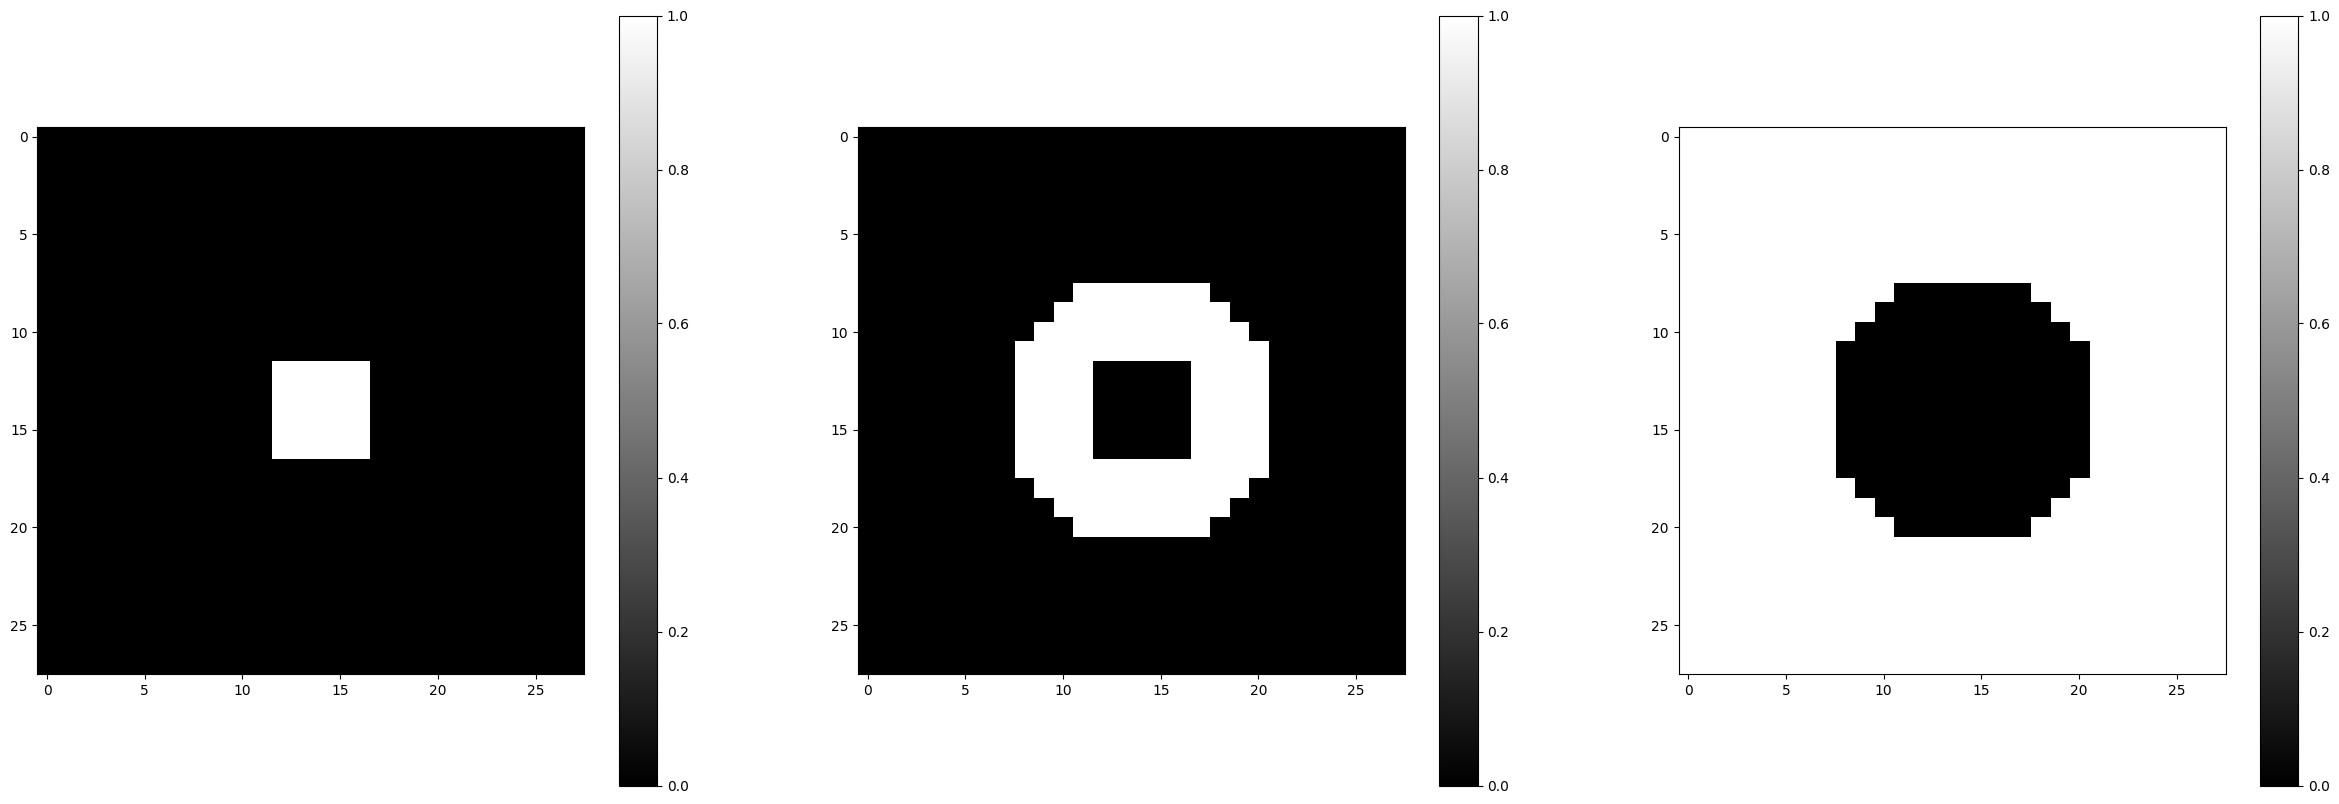

In [19]:
def draw_circle(shape, diameter):
    '''
    Input:
    shape    : tuple (height, width)
    diameter : scalar
    
    Output:
    np.array of shape that says True within a circle with diameter = around center
    '''
    assert len(shape) == 2
    TF = np.zeros(shape,dtype=np.bool)
    center = np.array(TF.shape)/2.0

    for iy in range(shape[0]):
        for ix in range(shape[1]):
            TF[iy,ix] = (iy- center[0])**2 + (ix - center[1])**2 < diameter **2
    return(TF)

circle_mask         = draw_circle(shape=sample_image.shape,diameter=3) # Change diameter to target different frequencies
outer_circle_mask   = draw_circle(shape=sample_image.shape, diameter=7)
ring_mask           = outer_circle_mask & ~circle_mask
outside_circle_mask = ~outer_circle_mask

fig = plt.figure(figsize=(30,10))
ax  = fig.add_subplot(1,3,1)
im  = ax.imshow(circle_mask,cmap="gray")
plt.colorbar(im)
ax  = fig.add_subplot(1,3,2)
im  = ax.imshow(ring_mask,cmap="gray")
plt.colorbar(im)
ax  = fig.add_subplot(1,3,3)
im  = ax.imshow(outside_circle_mask,cmap="gray")
plt.colorbar(im)
plt.show()

In [20]:
# Apply 2D FFT to the image
# - Transform from spatial domain (pixel values) to frequency domain
# - Frequencies near the center are low, frequencies near the edges are high
# - The center of the frequency domain corresponds to the average intensity of the image
# Then shift the zero frequency component to the center
# - See frequency components more intuitively

fft_img = np.fft.fftshift(np.fft.fft2(sample_image))

In [21]:
# From the full FFT filter, create a low-, medium-, and high-frequency filter
# low-frequency filter = inner circle
# medium-frequency filter = ring
# high-frequency filter = outside the outer circle

def filter_circle(circle_mask, full_fft_filter):
    temp = np.zeros(full_fft_filter.shape,dtype=complex)
    temp[circle_mask] = full_fft_filter[circle_mask]
    return(temp)

fft_img_filtered_IN = []
fft_img_filtered_RING = []
fft_img_filtered_OUT = []

# Entire image (all frequencies)
full_fft_filter  = fft_img

# Inside circle (low-frequency)
temp = filter_circle(circle_mask, full_fft_filter)
fft_img_filtered_IN.append(temp)

# Ring (medium-frequency)
temp = filter_circle(ring_mask, full_fft_filter)
fft_img_filtered_RING.append(temp)

# Outside circle (high-frequency)
temp = filter_circle(outside_circle_mask, full_fft_filter)
fft_img_filtered_OUT.append(temp) 

fft_img_filtered_IN = np.array(fft_img_filtered_IN)
fft_img_filtered_IN = np.transpose(fft_img_filtered_IN,(1,2,0))
fft_img_filtered_RING = np.array(fft_img_filtered_RING)
fft_img_filtered_RING = np.transpose(fft_img_filtered_RING,(1,2,0))
fft_img_filtered_OUT = np.array(fft_img_filtered_OUT)
fft_img_filtered_OUT = np.transpose(fft_img_filtered_OUT,(1,2,0))

In [22]:
abs_fft_img                 = np.abs(fft_img)
abs_fft_img_filtered_IN     = np.abs(fft_img_filtered_IN)
abs_fft_img_filtered_RING   = np.abs(fft_img_filtered_RING)
abs_fft_img_filtered_OUT    = np.abs(fft_img_filtered_OUT)

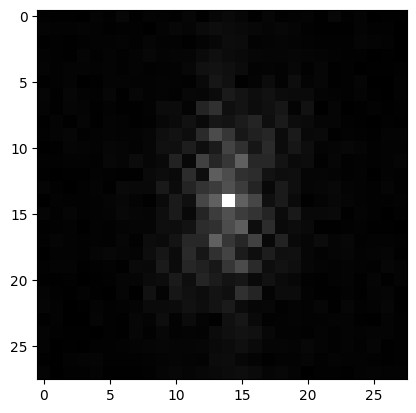

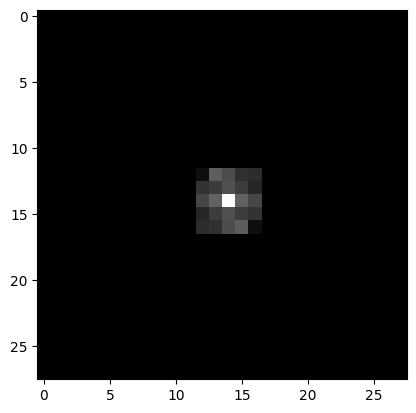

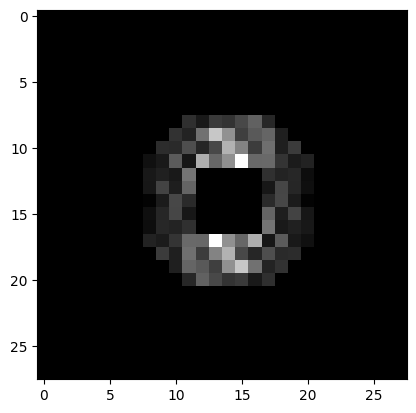

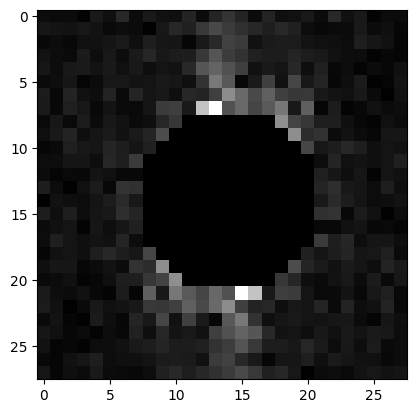

In [23]:
plt.imshow(abs_fft_img, cmap='gray')
plt.show()
plt.imshow(abs_fft_img_filtered_IN, cmap='gray')
plt.show()
plt.imshow(abs_fft_img_filtered_RING, cmap='gray')
plt.show()
plt.imshow(abs_fft_img_filtered_OUT, cmap='gray')
plt.show()

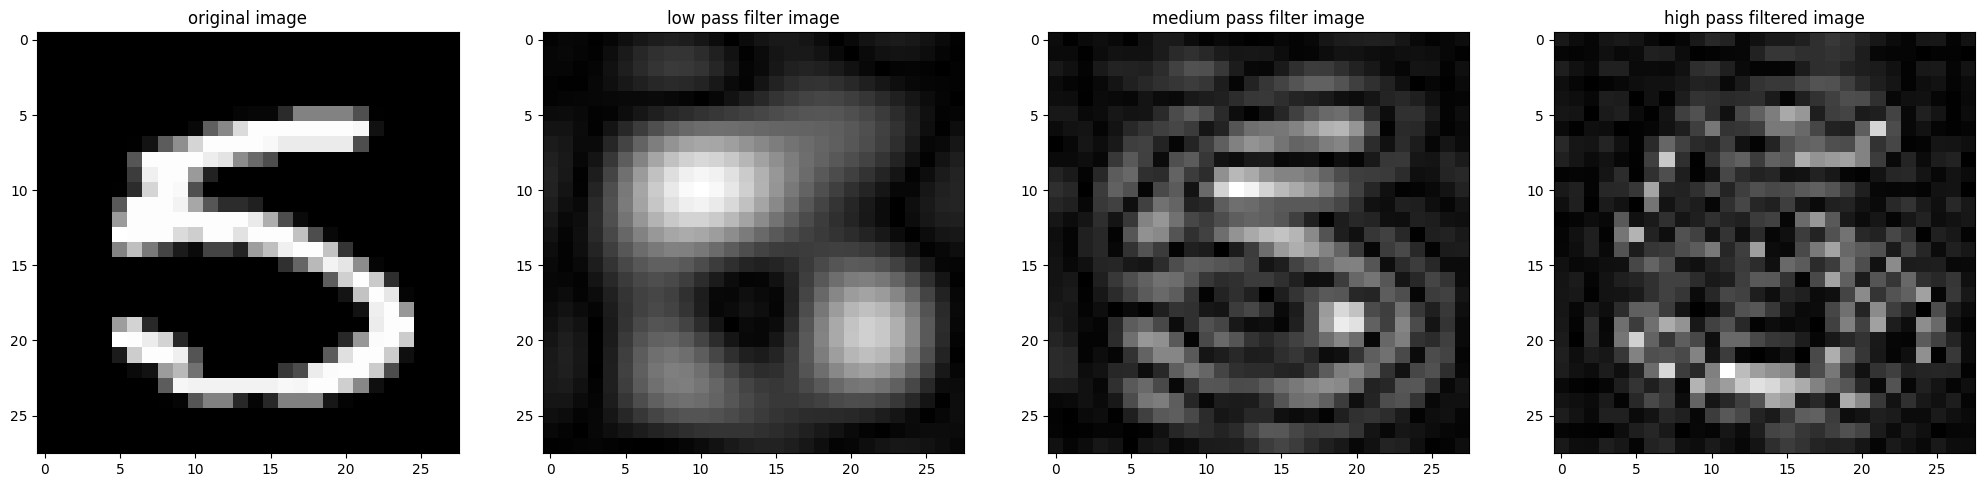

In [24]:
img_reco                = np.fft.ifft2(fft_img)
img_reco_filtered_IN    = np.fft.ifft2(fft_img_filtered_IN[:, :, 0])
img_reco_filtered_RING  = np.fft.ifft2(fft_img_filtered_RING[:, :, 0])
img_reco_filtered_OUT   = np.fft.ifft2(fft_img_filtered_OUT[:, :, 0])

fig = plt.figure(figsize=(25,18))
ax  = fig.add_subplot(1,4,1)
ax.imshow(np.abs(img_reco), cmap='gray')
ax.set_title("original image")

ax  = fig.add_subplot(1,4,2)
ax.imshow(np.abs(img_reco_filtered_IN), cmap='gray')
ax.set_title("low pass filter image")

ax  = fig.add_subplot(1,4,3)
ax.imshow(np.abs(img_reco_filtered_RING), cmap='gray')
ax.set_title("medium pass filter image")

ax  = fig.add_subplot(1,4,4)
ax.imshow(np.abs(img_reco_filtered_OUT), cmap='gray')
ax.set_title("high pass filtered image")
plt.show()

In [ ]:
def add_gaussian_noise(image, noise_level=0.1):
    fft_img = np.fft.fftshift(np.fft.fft2(image))

    fft_img_filter = []

    full_fft_filter  = fft_img
    fft_img_filter.append(full_fft_filter)
    
    fft_img_filter = np.array(fft_img_filter)
    fft_img_filter = np.transpose(fft_img_filter,(1,2,0))

    # Multiply all frequencies by (1 + noise_level * random_noise)
    noise = np.random.randn(*fft_img_filter.shape)
    fft_img_filter += noise_level * noise

    np.abs(fft_img_filter)
    img_reco_filter  = np.fft.ifft2(fft_img_filter[:, :, 0])

    return np.abs(img_reco_filter)

def add_low_frequency_noise(image, noise_level=0.1, diameter=4):
    circle_mask = draw_circle(shape=sample_image.shape,diameter=diameter)

    fft_img = np.fft.fftshift(np.fft.fft2(image))
    
    fft_img_filtered_IN = []

    full_fft_filter  = fft_img
    # Inside circle (low-frequency)
    temp = filter_circle(circle_mask, full_fft_filter)
    fft_img_filtered_IN.append(temp)
    
    fft_img_filtered_IN = np.array(fft_img_filtered_IN)
    fft_img_filtered_IN = np.transpose(fft_img_filtered_IN,(1,2,0))

    # Multiply the low-frequency components by (1 + noise_level * random_noise)
    noise = np.random.randn(*fft_img_filtered_IN.shape)
    fft_img_filtered_IN += noise_level * noise

    np.abs(fft_img_filtered_IN)
    img_reco_filtered_IN  = np.fft.ifft2(fft_img_filtered_IN[:, :, 0])

    return np.abs(img_reco_filtered_IN)

def add_medium_frequency_noise(image, noise_level=0.1, inner_diameter=3, outer_diameter=7):
    circle_mask         = draw_circle(shape=sample_image.shape,diameter=inner_diameter)
    outer_circle_mask   = draw_circle(shape=sample_image.shape, diameter=outer_diameter)
    ring_mask           = outer_circle_mask & ~circle_mask

    fft_img = np.fft.fftshift(np.fft.fft2(image))
    
    fft_img_filtered_RING = []

    full_fft_filter  = fft_img
    # Ring (medium-frequency)
    temp = filter_circle(ring_mask, full_fft_filter)
    fft_img_filtered_RING.append(temp)
    fft_img_filtered_RING = np.array(fft_img_filtered_RING)
    fft_img_filtered_RING = np.transpose(fft_img_filtered_RING,(1,2,0))

    # Multiply the medium-frequency components by (1 + noise_level * random_noise)
    noise = np.random.randn(*fft_img_filtered_RING.shape)
    fft_img_filtered_RING += noise_level * noise

    np.abs(fft_img_filtered_RING)
    img_reco_filtered_RING = np.fft.ifft2(fft_img_filtered_RING[:, :, 0])

    return np.abs(img_reco_filtered_RING)

def add_high_frequency_noise(image, noise_level=0.1, diameter=8):
    outer_circle_mask   = draw_circle(shape=sample_image.shape, diameter=diameter)
    outside_circle_mask = ~outer_circle_mask

    fft_img = np.fft.fftshift(np.fft.fft2(image))

    fft_img_filtered_OUT = []

    full_fft_filter  = fft_img
    # Outside circle (high-frequency)
    temp = filter_circle(outside_circle_mask, full_fft_filter)
    fft_img_filtered_OUT.append(temp) 

    fft_img_filtered_OUT = np.array(fft_img_filtered_OUT)
    fft_img_filtered_OUT = np.transpose(fft_img_filtered_OUT,(1,2,0))

    # Multiply the high-frequency components by (1 + noise_level * random_noise)
    noise = np.random.randn(*fft_img_filtered_OUT.shape)
    fft_img_filtered_OUT += noise_level * noise

    np.abs(fft_img_filtered_OUT)
    img_reco_filtered_OUT = np.fft.ifft2(fft_img_filtered_OUT[:, :, 0])

    return np.abs(img_reco_filtered_OUT)

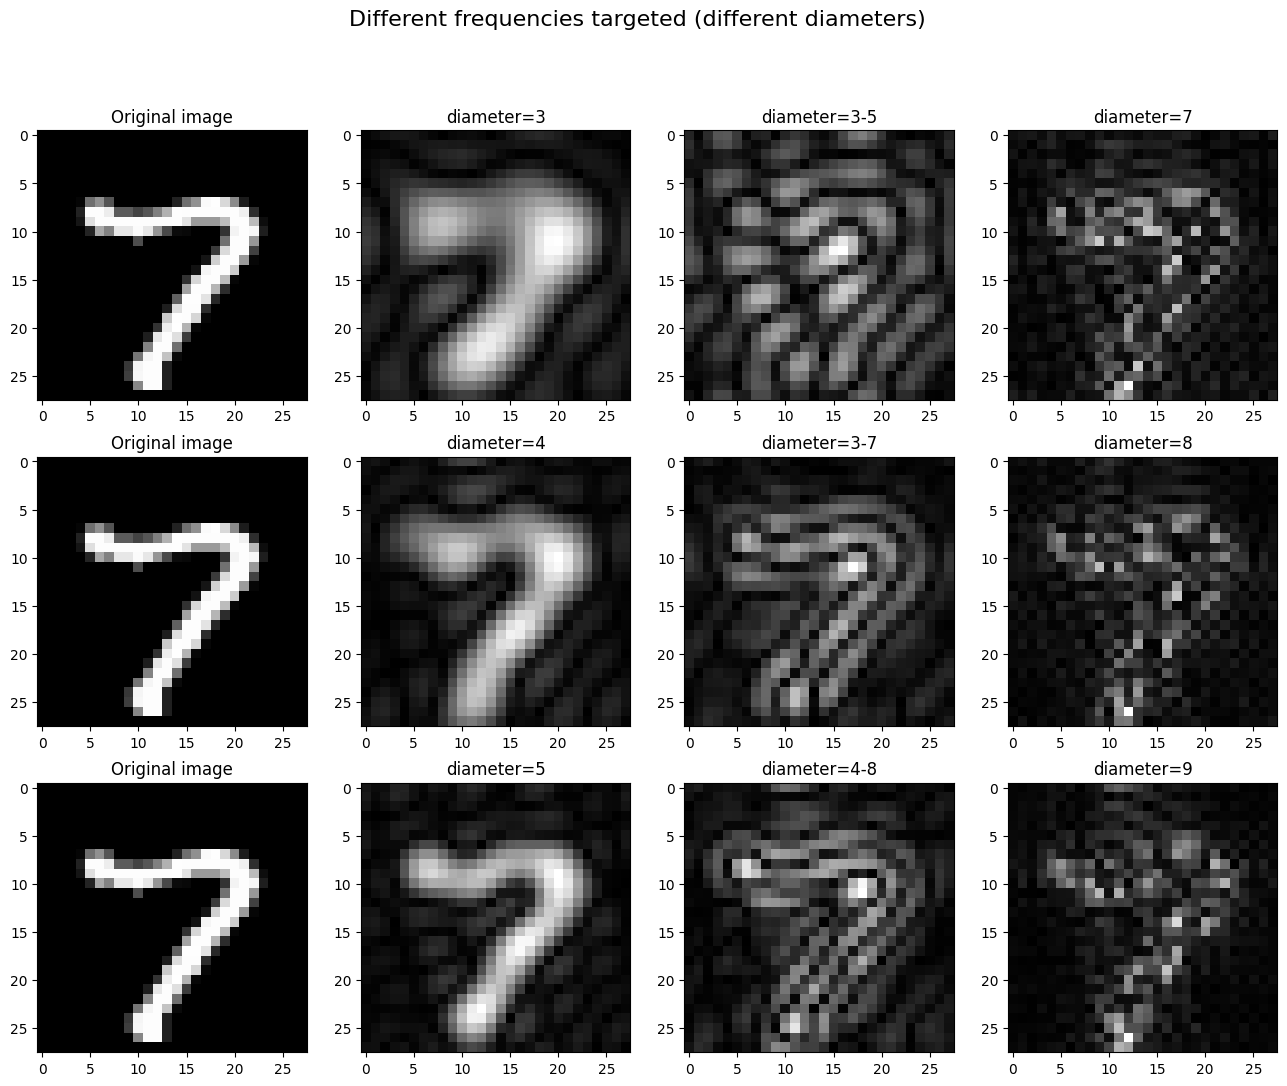

In [38]:
sample_image = train_images[2, 0]

fig = plt.figure(figsize=(16, 12))
fig.suptitle("Different frequencies targeted (different diameters)", fontsize=16)

ax  = fig.add_subplot(3,4,1)
ax.imshow(sample_image, cmap='gray')
ax.set_title("Original image")

ax  = fig.add_subplot(3,4,2)
ax.imshow(add_low_frequency_noise(sample_image, noise_level=0.1, diameter=3), cmap='gray')
ax.set_title("diameter=3")

ax  = fig.add_subplot(3,4,3)
ax.imshow(add_medium_frequency_noise(sample_image, noise_level=0.1, inner_diameter=3, outer_diameter=5), cmap='gray')
ax.set_title("diameter=3-5")

ax  = fig.add_subplot(3,4,4)
ax.imshow(add_high_frequency_noise(sample_image, noise_level=0.1, diameter=7), cmap='gray')
ax.set_title("diameter=7")

ax  = fig.add_subplot(3,4,5)
ax.imshow(sample_image, cmap='gray')
ax.set_title("Original image")

ax  = fig.add_subplot(3,4,6)
ax.imshow(add_low_frequency_noise(sample_image, noise_level=0.1, diameter=4), cmap='gray')
ax.set_title("diameter=4")

ax  = fig.add_subplot(3,4,7)
ax.imshow(add_medium_frequency_noise(sample_image, noise_level=0.1, inner_diameter=3, outer_diameter=7), cmap='gray')
ax.set_title("diameter=3-7")

ax  = fig.add_subplot(3,4,8)
ax.imshow(add_high_frequency_noise(sample_image, noise_level=0.1, diameter=8), cmap='gray')
ax.set_title("diameter=8")

ax  = fig.add_subplot(3,4,9)
ax.imshow(sample_image, cmap='gray')
ax.set_title("Original image")

ax  = fig.add_subplot(3,4,10)
ax.imshow(add_low_frequency_noise(sample_image, noise_level=0.1, diameter=5), cmap='gray')
ax.set_title("diameter=5")

ax  = fig.add_subplot(3,4,11)
ax.imshow(add_medium_frequency_noise(sample_image, noise_level=0.1, inner_diameter=4, outer_diameter=8), cmap='gray')
ax.set_title("diameter=4-8")

ax  = fig.add_subplot(3,4,12)
ax.imshow(add_high_frequency_noise(sample_image, noise_level=0.1, diameter=9), cmap='gray')
ax.set_title("diameter=9")

plt.show()

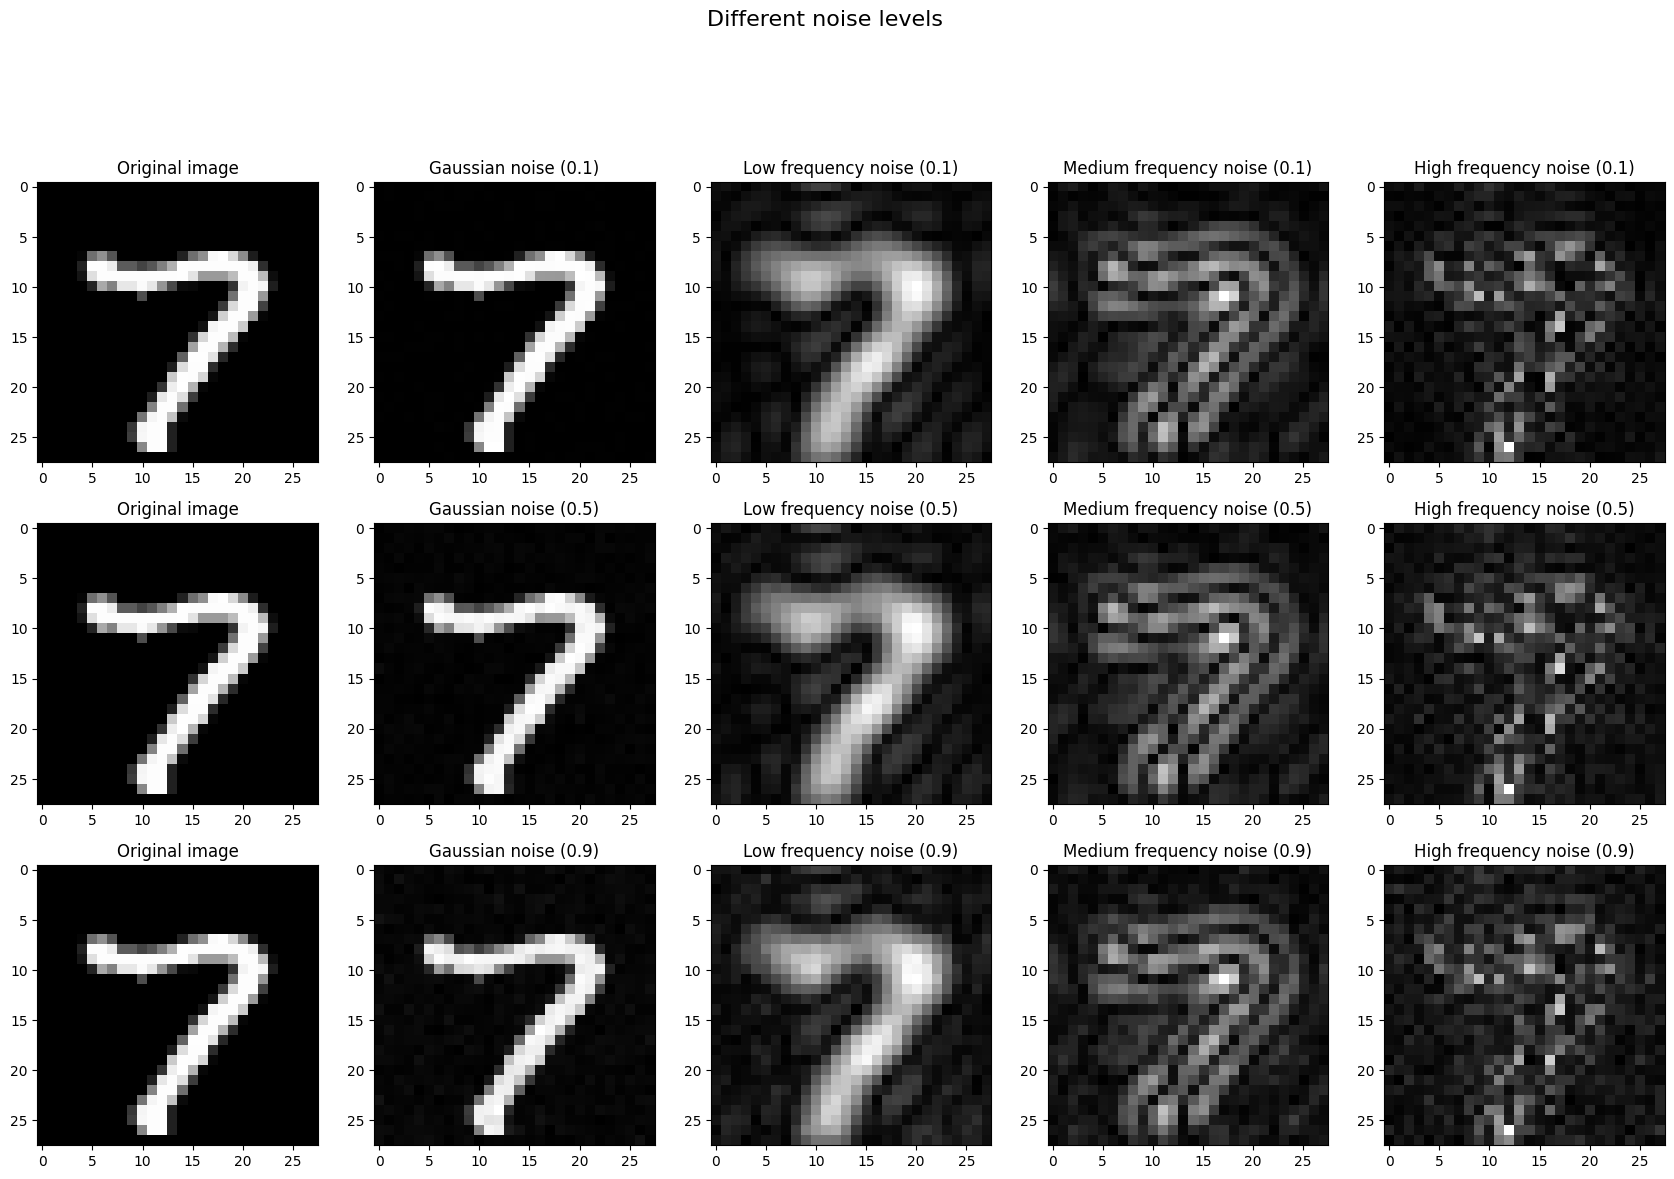

In [46]:
fig = plt.figure(figsize=(21,17))
fig.suptitle("Different noise levels", fontsize=16)

ax  = fig.add_subplot(4,5,1)
ax.imshow(sample_image, cmap='gray')
ax.set_title("Original image")

ax  = fig.add_subplot(4,5,2)
ax.imshow(add_gaussian_noise(sample_image, noise_level=0.1), cmap='gray')
ax.set_title("Gaussian noise (0.1)")

ax  = fig.add_subplot(4,5,3)
ax.imshow(add_low_frequency_noise(sample_image, noise_level=0.1), cmap='gray')
ax.set_title("Low frequency noise (0.1)")

ax  = fig.add_subplot(4,5,4)
ax.imshow(add_medium_frequency_noise(sample_image, noise_level=0.1), cmap='gray')
ax.set_title("Medium frequency noise (0.1)")

ax  = fig.add_subplot(4,5,5)
ax.imshow(add_high_frequency_noise(sample_image, noise_level=0.1), cmap='gray')
ax.set_title("High frequency noise (0.1)")

ax  = fig.add_subplot(4,5,6)
ax.imshow(sample_image, cmap='gray')
ax.set_title("Original image")

ax  = fig.add_subplot(4,5,7)
ax.imshow(add_gaussian_noise(sample_image, noise_level=0.5), cmap='gray')
ax.set_title("Gaussian noise (0.5)")

ax  = fig.add_subplot(4,5,8)
ax.imshow(add_low_frequency_noise(sample_image, noise_level=0.5), cmap='gray')
ax.set_title("Low frequency noise (0.5)")

ax  = fig.add_subplot(4,5,9)
ax.imshow(add_medium_frequency_noise(sample_image, noise_level=0.5), cmap='gray')
ax.set_title("Medium frequency noise (0.5)")

ax  = fig.add_subplot(4,5,10)
ax.imshow(add_high_frequency_noise(sample_image, noise_level=0.5), cmap='gray')
ax.set_title("High frequency noise (0.5)")

ax  = fig.add_subplot(4,5,11)
ax.imshow(sample_image, cmap='gray')
ax.set_title("Original image")

ax  = fig.add_subplot(4,5,12)
ax.imshow(add_gaussian_noise(sample_image, noise_level=0.9), cmap='gray')
ax.set_title("Gaussian noise (0.9)")

ax  = fig.add_subplot(4,5,13)
ax.imshow(add_low_frequency_noise(sample_image, noise_level=0.9), cmap='gray')
ax.set_title("Low frequency noise (0.9)")

ax  = fig.add_subplot(4,5,14)
ax.imshow(add_medium_frequency_noise(sample_image, noise_level=0.9), cmap='gray')
ax.set_title("Medium frequency noise (0.9)")

ax  = fig.add_subplot(4,5,15)
ax.imshow(add_high_frequency_noise(sample_image, noise_level=0.9), cmap='gray')
ax.set_title("High frequency noise (0.9)")

plt.show()